In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from spikenet.network import Network
from spikenet.image_to_spike_convertor import ImageToSpikeConvertor, SpikePlotter
from IPython.display import HTML

splt = SpikePlotter()

In [2]:
class MyData(ImageToSpikeConvertor):
    RESIZE_SIZE = (16, 16)

    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            train_data=torchvision.datasets.MNIST(
                root="./data",
                train=True,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
                download=True,
            ),
            test_data=torchvision.datasets.MNIST(
                root="./data",
                train=False,
                transform=torchvision.transforms.Compose(
                    [
                        torchvision.transforms.Resize(self.RESIZE_SIZE),
                        transforms.ToTensor(),
                    ]
                ),
            ),
            **kwargs
        )

    def x_transform(self, x):
        x = super().x_transform(x)
        res = x.reshape(-1, self.time_scale, self.RESIZE_SIZE[0] * self.RESIZE_SIZE[1])
        return res

    # def y_transform(self, y: torch.Any) -> torch.Any:
    #     y = super().y_transform(y)
    #     # to one hot
    #     y = torch.nn.functional.one_hot(y, num_classes=10).to(torch.float32)
    #     return y


data = MyData()#apply_softening=False)
input_shape, output_shape = data.shape
data.describe()

shape:
  - x: torch.Size([16, 256])
  - y: torch.Size([])
  - batch_size: 128


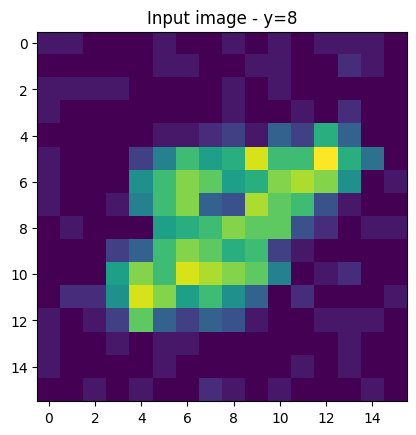

In [3]:
test_data = data.sample()
data_x, data_y = test_data

img = data_x.reshape([16, 16, 16])
img = img.sum(0)
plt.imshow(img)
plt.title(f"Input image - y={data_y}")
plt.show()

# for time in range(16):
#     frame = data_x[time].reshape([16, 16])
#     plt.imshow(frame)
#     plt.show()

In [4]:
class LinearReLU(torch.nn.Module):
    def __init__(self, in_features, out_features, activation=None):
        self.in_features = in_features
        self.out_features = out_features
        self.name='LinearReLU'
        super(LinearReLU, self).__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.activation = torch.nn.ReLU() if activation is None else activation

    def initialize_parameters(self):
        pass

    def clamp(self):
        pass

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

In [5]:
from spikenet.layers.spiking_base import TimeReduction
from spikenet.layers.spiking_dense import SpikingDenseLayer
from torch.nn import Softmax

# net = (
#     Network()
#     .add_layer(SpikingDenseLayer, 1000, in_features=input_shape[1])
#     .add_layer(SpikingDenseLayer, 200)
#     # .add_layer(SpikingDenseLayer, 100)
#     # .add_layer(SpikingDenseLayer, 100, name="l1b")
#     .add_layer(SpikingDenseLayer, 10, time_reduction=TimeReduction.MemRecMax)
# ).build()
# net.forward(data_x.reshape([1, *data_x.shape]))

net = (
    Network.from_parameters(
        # encoding=None,
        loss_fn=torch.nn.CrossEntropyLoss
    )
    # ANN
    # .add_layer(LinearReLU, in_features=input_shape[0], out_features=600)
    # .add_layer(LinearReLU, in_features=600, out_features=10, activation=Softmax())

    # SNN
    .add_layer(SpikingDenseLayer, 400, in_features=input_shape[1])
    .add_layer(SpikingDenseLayer, 10, time_reduction=TimeReduction.MemRecMax)
).build()

# net.forward(data_x)
# net.plot_activity()

In [6]:
# net.forward(data_x.reshape([1, *data_x.shape]))
# net.plot_activity()


===== Training Started ======
Epoch 0 | ............................................... | Loss: 1.7183
Epoch 1 | ............................................... | Loss: 1.0005
Epoch 2 | ............................................... | Loss: 0.8256
Epoch 3 | ............................................... | Loss: 0.4451
Epoch 4 | ............................................... | Loss: 0.6190
===== Training Finished =====


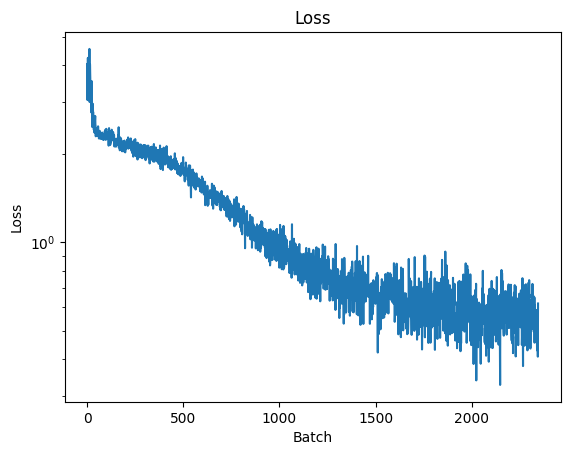

====== Testing Started ======
Accuracy: 8631/10000 = 86.31%
===== Testing Finished ======


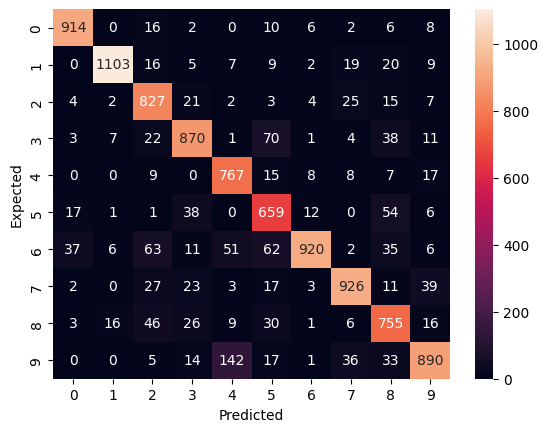

My Network:
ModuleList(
  (0-1): 2 x SpikingDenseLayer()
)

In [7]:
net.fit(data)

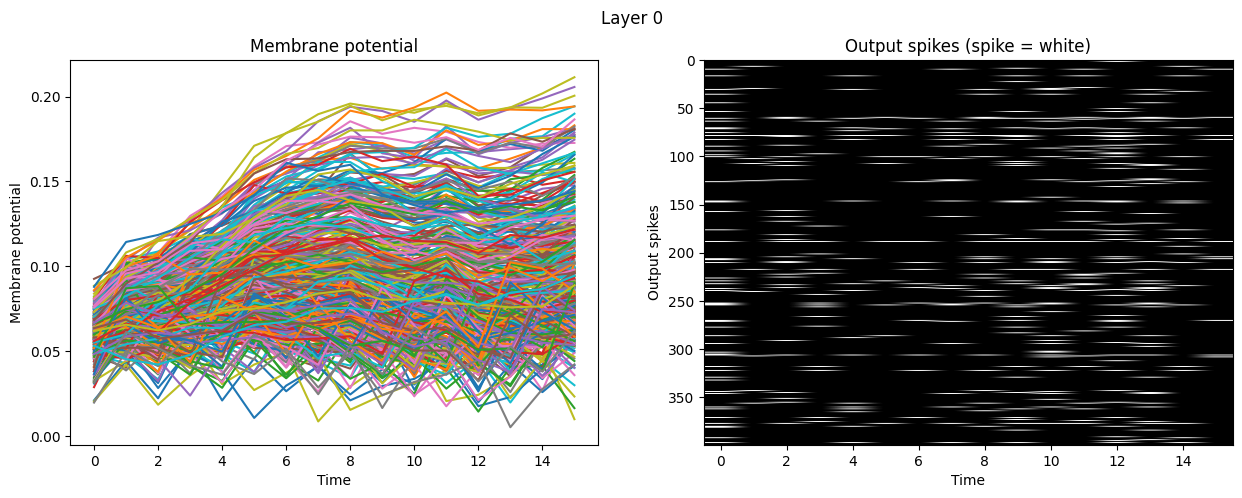

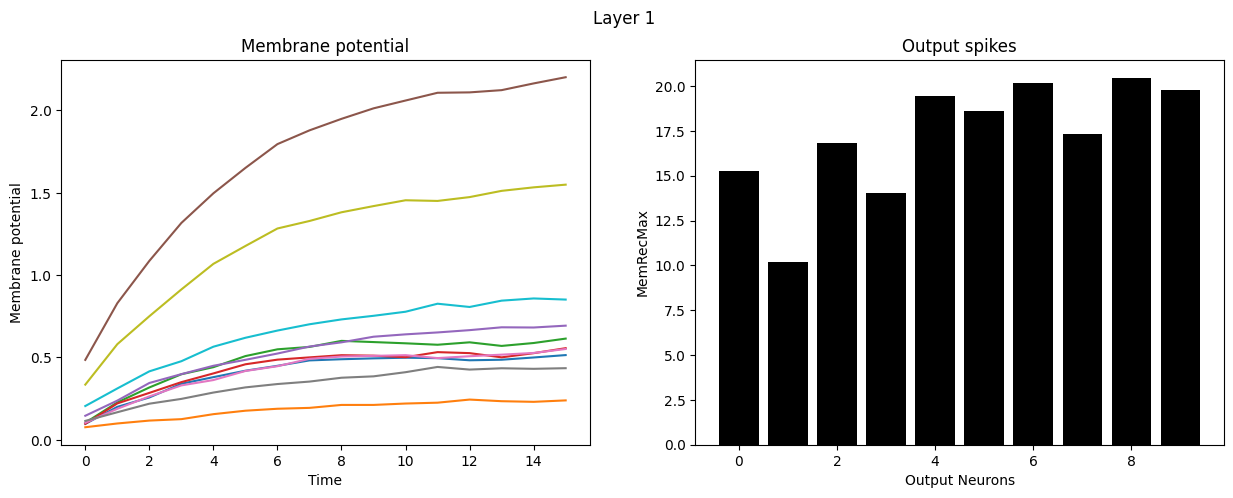

In [16]:
net.forward(data_x.reshape([1, *data_x.shape]))
net.plot_activity()

In [9]:
# layer_res = list(net.forward_by_layer(data_x.reshape([1, *data_x.shape])))

# num_layers = len(net.layers)
# lyr: SpikingDenseLayer
# fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
# for i, lyr in enumerate(net.layers):
#     lyr.plot_history(ax=axs[i], key="mem")
#     axs[i].set_title(f"Layer {i}")
#     axs[i].set_xlabel("Time")
#     axs[i].set_ylabel("Membrane Potential")
# plt.show()

# fig, axs = plt.subplots(1, num_layers, figsize=(10, 5))
# for i, lyr in enumerate(net.layers):
#     lyr.plot_history(ax=axs[i], key="spk")
#     axs[i].set_title(f"Layer {i}")
#     axs[i].set_xlabel("Time")
#     axs[i].set_ylabel("Spikes")
# plt.show()

In [10]:
# for res in layer_res:
#     res = res[0, ...].detach().numpy()
#     shp = res.shape
#     if len(shp) == 2:
#         plt.imshow(res, cmap="gray")
#     elif len(shp) == 1:
#         plt.bar(range(shp[0]), res)
#     plt.title(f"Layer {i}")
#     plt.show()

In [11]:
# lyr: SpikingDenseLayer
# # fig, axs = plt.subplots(1, 5, figsize=(10, 5))
# # for lyr in net.layers:
# #     lyr.plot_snapshot(axs)
# # plt.show()

# # fig, axs = plt.subplots(1, 5, figsize=(10, 5))
# # for lyr in net.layers:
# #     lyr.plot_snapshot_diff(axs)
# # plt.show()

# lyr = net.layers[0]
# lyr.all_snapshots()

In [12]:
# fix, axs = plt.subplots(1, 2, figsize=(10, 5))
# for i in range(len(net.layers)):
#     net.layers[i].plot_history(axs[i])
# plt.show()
# # # mem = net.layers[0].get_history("mem")
# # # mem.shape
# # # res = splt.animate(mem)
# # # HTML(res)

In [13]:
# mem = net.layers[0].get_history("mem")
# plt.imshow(mem.reshape(-1, 100), cmap="gray")
# plt.xlabel("Neurons")
# plt.ylabel("Time")
# plt.show()

# for i in range(10):
#     plt.plot(mem[0, :, i], label=f"Neuron {i}")
# plt.xlabel("Time")
# plt.ylabel("Membrane Potential")
# plt.show()

In [14]:
# mem = net.layers[1].get_history("mem")
# for i in range(10):
#     plt.plot(mem[0, :, i], label=f"Neuron {i}")
# # plt.plot(mem.reshape(-1, 10), cmap="gray")
# plt.xlabel("Neurons")
# plt.ylabel("Time")
# plt.show()

In [15]:
# plt.imshow(net.layers[0].w.detach().numpy())
# plt.xlabel("Neurons")
# plt.ylabel("Input")
# plt.show()

In [7]:
# import re

# unix_path_regex = r'^(/?|(\./|../)?)([\w-]+/)*([\w.\-]+)?$'
# windows_path_regex = r'^(?:(?:[a-zA-Z]:\\)|(?:\\\\[\w\s-]+\\[\w\s-]+\\)|(?:\.\.\\)|(?:\.\\))?([\w\s-]+\\)*[\w\s.-]*$'


# def test_path_regex(regex, path, should_be):
#     res = bool(re.match(regex, path))
#     if should_be != res:
#         print(f"{path}\t\t[result={res}, should-be={should_be}]")
    
# # Test Unix-like paths
# print("Testing Unix-like paths:")
# test_path_regex(unix_path_regex, "/home/user/example.txt", True)
# test_path_regex(unix_path_regex, "../another_directory/file.txt", True)
# test_path_regex(unix_path_regex, "./current_directory/file.txt", True)
# test_path_regex(unix_path_regex, ".", True)

# # unix false paths
# test_path_regex(unix_path_regex, "C:\\Users\\User\\Documents\\example.txt", False)
# test_path_regex(unix_path_regex, "\\Server\Share\file.txt", False)
# test_path_regex(unix_path_regex, "..\\another_directory\\file.txt", False)
# test_path_regex(unix_path_regex, "./here\\file.txt", False)
# test_path_regex(unix_path_regex, ".//file.txt", False)
# test_path_regex(unix_path_regex, "./\\file.txt", False)


# # Test Windows paths
# print("\nTesting Windows paths:")
# test_path_regex(windows_path_regex, "C:\\Users\\User\\Documents\\example.txt", True)
# test_path_regex(windows_path_regex, "\\Server\Share\file.txt", True)
# test_path_regex(windows_path_regex, "..\\another_directory\\file.txt", True)
# test_path_regex(windows_path_regex, ".\\current_directory\\file.txt", True)
# test_path_regex(windows_path_regex, ".", True)

# # windows false paths
# test_path_regex(windows_path_regex, "/home/user/example.txt", False)
# test_path_regex(windows_path_regex, "../another_directory/file.txt", False)
# test_path_regex(windows_path_regex, "./current_directory/file.txt", False)
# test_path_regex(windows_path_regex, ".\\\\file.txt", False)
# test_path_regex(windows_path_regex, "C\\file", False)
# test_path_regex(windows_path_regex, "C:\\$file.txt", False)

Testing Unix-like paths:
.//file.txt		[result=True, should-be=False]

Testing Windows paths:
\Server\Shareile.txt		[result=False, should-be=True]
C\file		[result=True, should-be=False]
